In [10]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time
from joblib import Parallel, delayed
from skimage.util.shape import view_as_windows
from skimage.feature import greycomatrix, greycoprops
import math 


plt.rcParams["figure.figsize"] = (18,16)
features = ["dissimilarity","contrast","correlation","energy" ]
angles= [math.radians(degree) for degree in range(0,360,15)]

In [11]:
img_1 = cv2.imread("./img1.jpg",0)
img_2 = cv2.imread("./img2.jpg",0)

def PatchMakers(in_img,shape):
    win_shape = (shape,shape)
    return view_as_windows(in_img,window_shape=win_shape)


def GLCMCalculator(img , levels , distances, angles, feature):
    GLCM = greycomatrix(img, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    result = np.asarray([greycoprops(GLCM, f).reshape(-1) for f in feature]).reshape(-1)
    return result



def Segmentation(img ,p_shape,resize_ratio=0.4, levels=16, workers = 16, distances=[], angles=[], features = [], k=3):
    start = time.time()
    img_resized = cv2.resize(img, None, fx = resize_ratio, fy = resize_ratio)
    h,w = img_resized.shape

    gray_factor = 256//levels
    img = img_resized//gray_factor

    patches = PatchMakers(img,p_shape)
    patches = patches.reshape((patches.shape[0] *patches.shape[1] ,p_shape,p_shape))
    GLCM_array = []
    GLCM_array.extend(Parallel(n_jobs=workers)(delayed(GLCMCalculator)(patches[index],levels,distances,angles,features) for index in range(patches.shape[0])))
        
    scaler = StandardScaler()
    scaler.fit(GLCM_array)
    standard_result = scaler.transform(GLCM_array)
    
    
    kmeans = KMeans(n_clusters=k).fit(standard_result)
    end = time.time()
    duration =  round(end- start,2)
    pred = kmeans.labels_
    output_final = pred.reshape((h-p_shape+1,w-p_shape+1))

    plt.subplot(2,1,1)
    plt.imshow(img,cmap="gray")
    plt.axis("off")
    plt.title("Input Image | Levels:{0}, Resize Ratio:{1}".format(levels,resize_ratio))
    plt.subplot(2,1,2)
    plt.imshow(output_final)
    plt.title("GLCM based Segmentation using K-Means | Workers:{0}, Patch Size:{2}x{2}, Distances{4}, Duration:{5}s".format(workers,levels,p_shape,resize_ratio,distances,duration))
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    

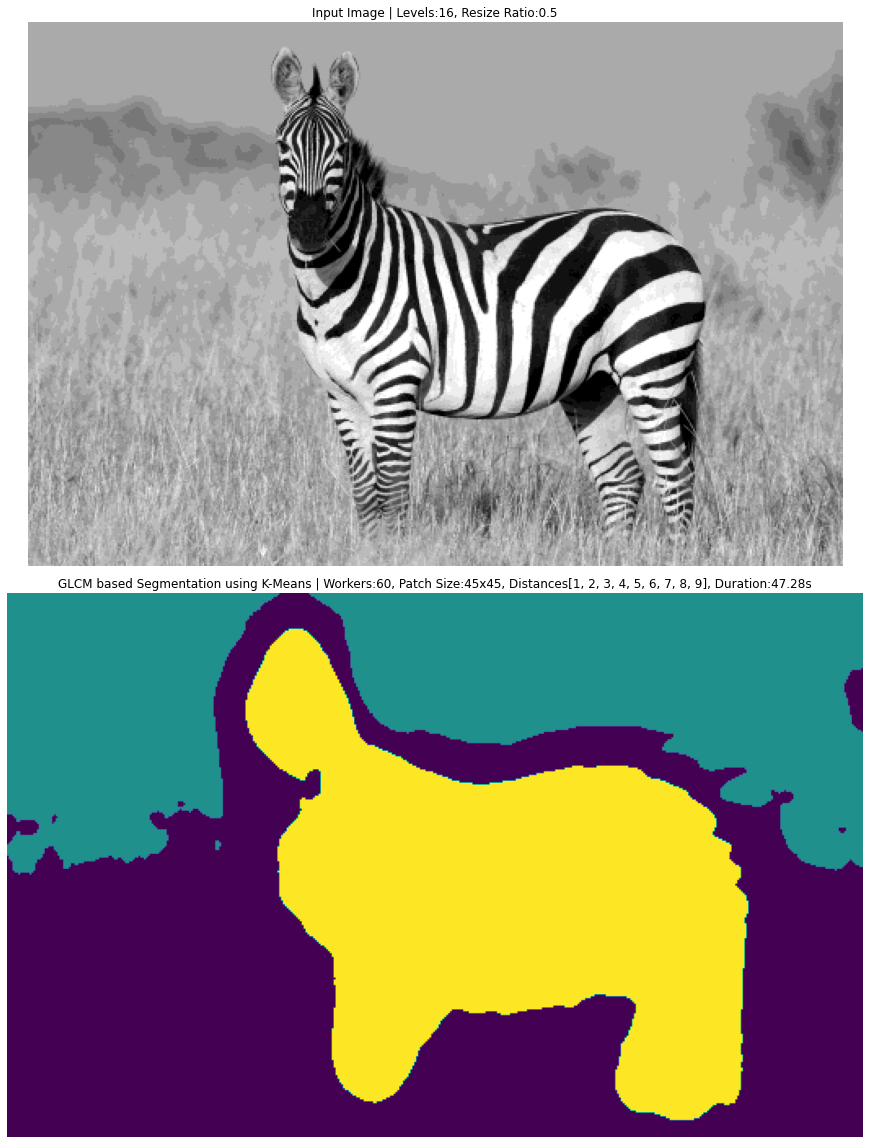

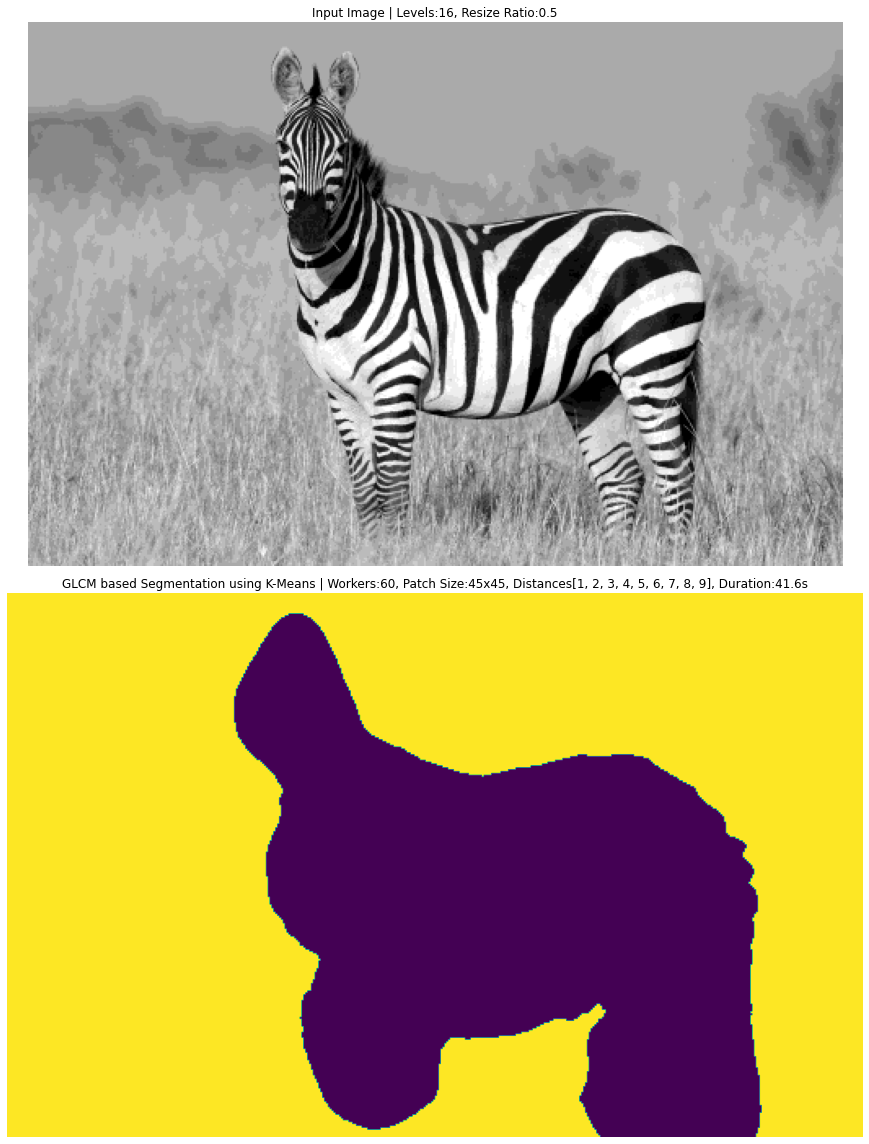

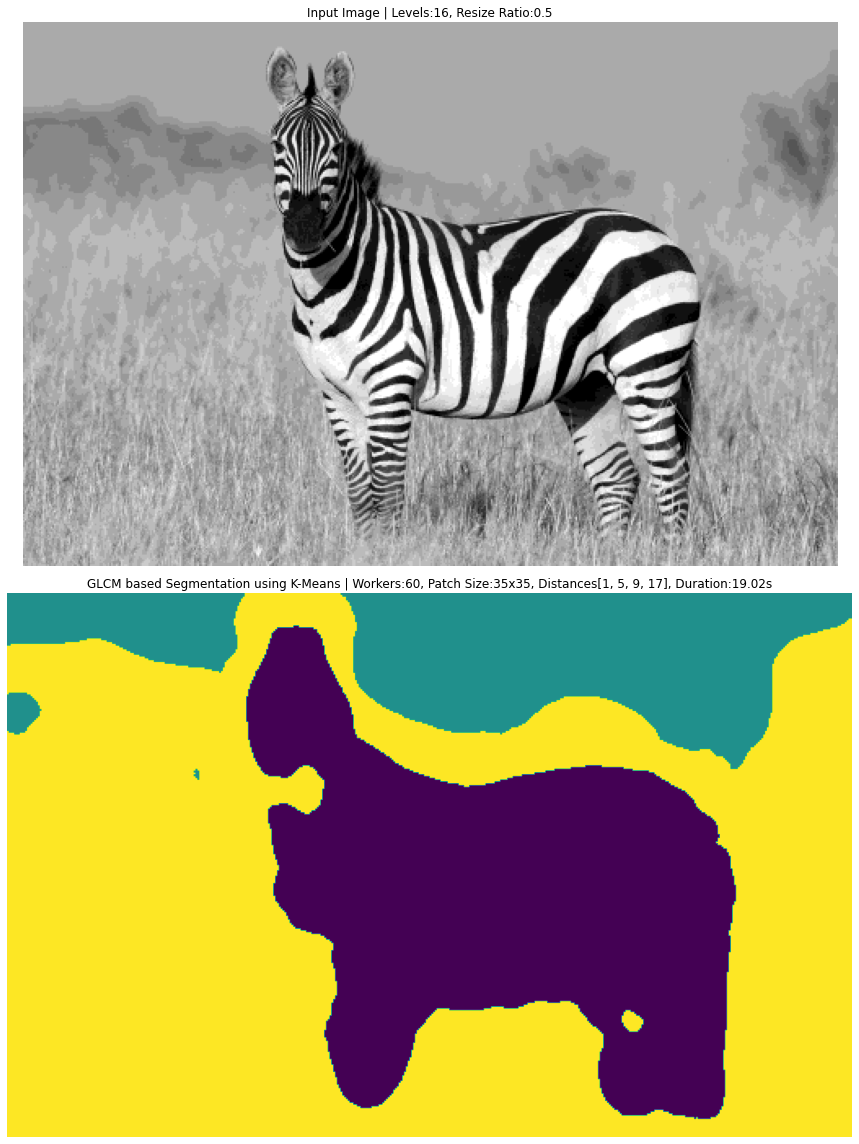

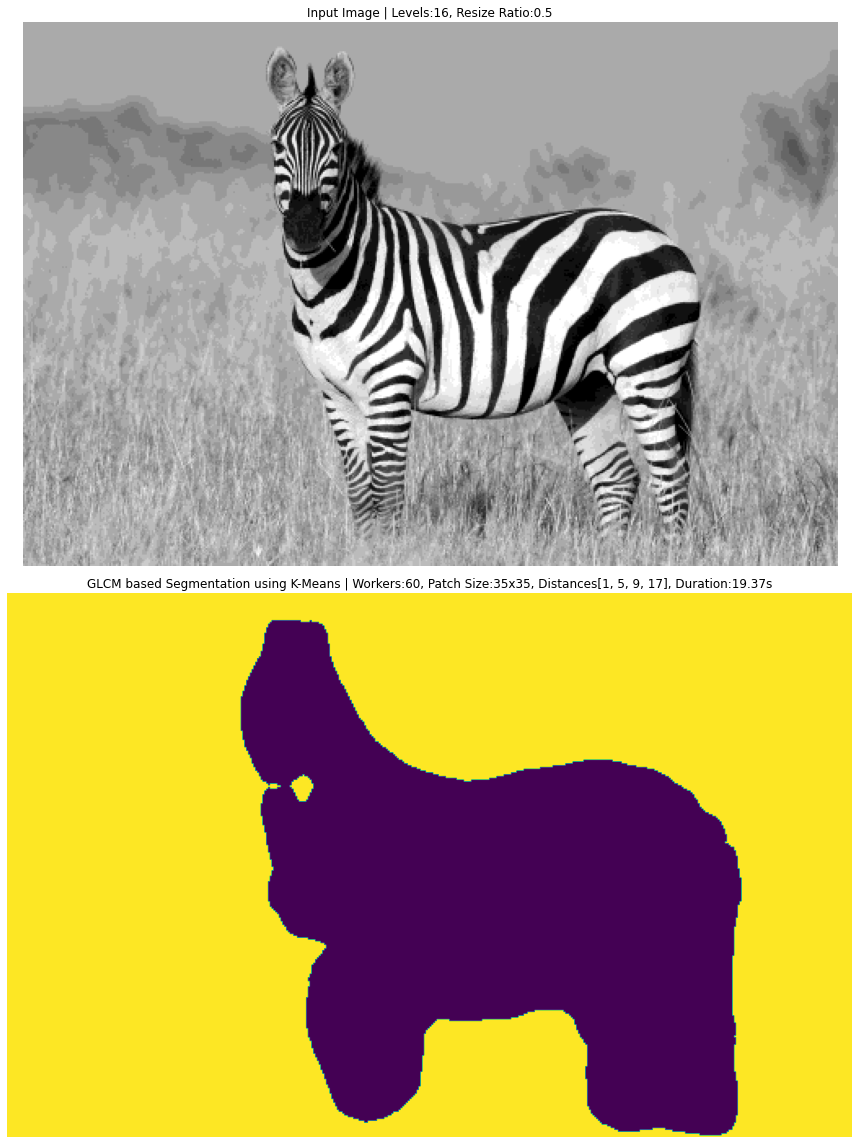

In [12]:
Segmentation(img_1,p_shape=45,resize_ratio=0.5,levels=16,workers = 60, distances=list(range(1,10)), angles=angles, features = features, k=3)
Segmentation(img_1,p_shape=45,resize_ratio=0.5,levels=16,workers = 60, distances=list(range(1,10)), angles=angles, features = features, k=2)

Segmentation(img_1,p_shape=35,resize_ratio=0.5,levels=16,workers = 60, distances=[1,5,9,17], angles=angles, features = features, k=3)
Segmentation(img_1,p_shape=35,resize_ratio=0.5,levels=16,workers = 60, distances=[1,5,9,17], angles=angles, features = features, k=2)


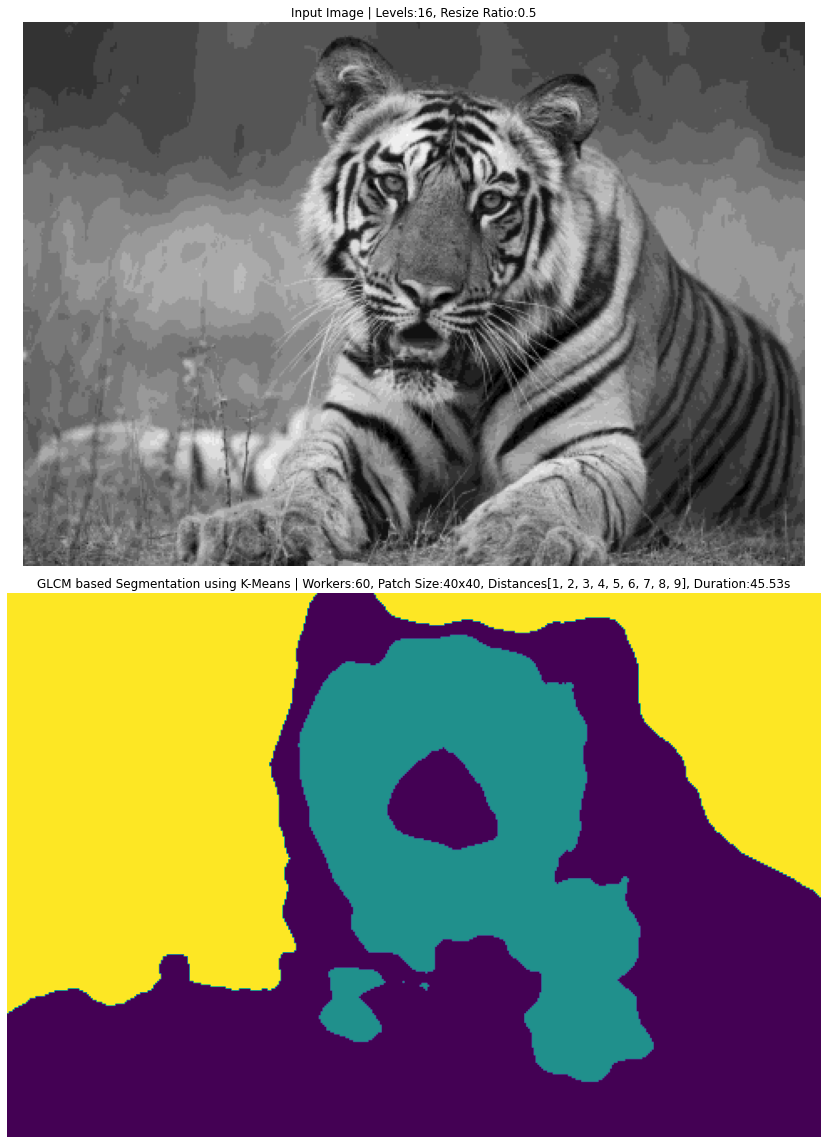

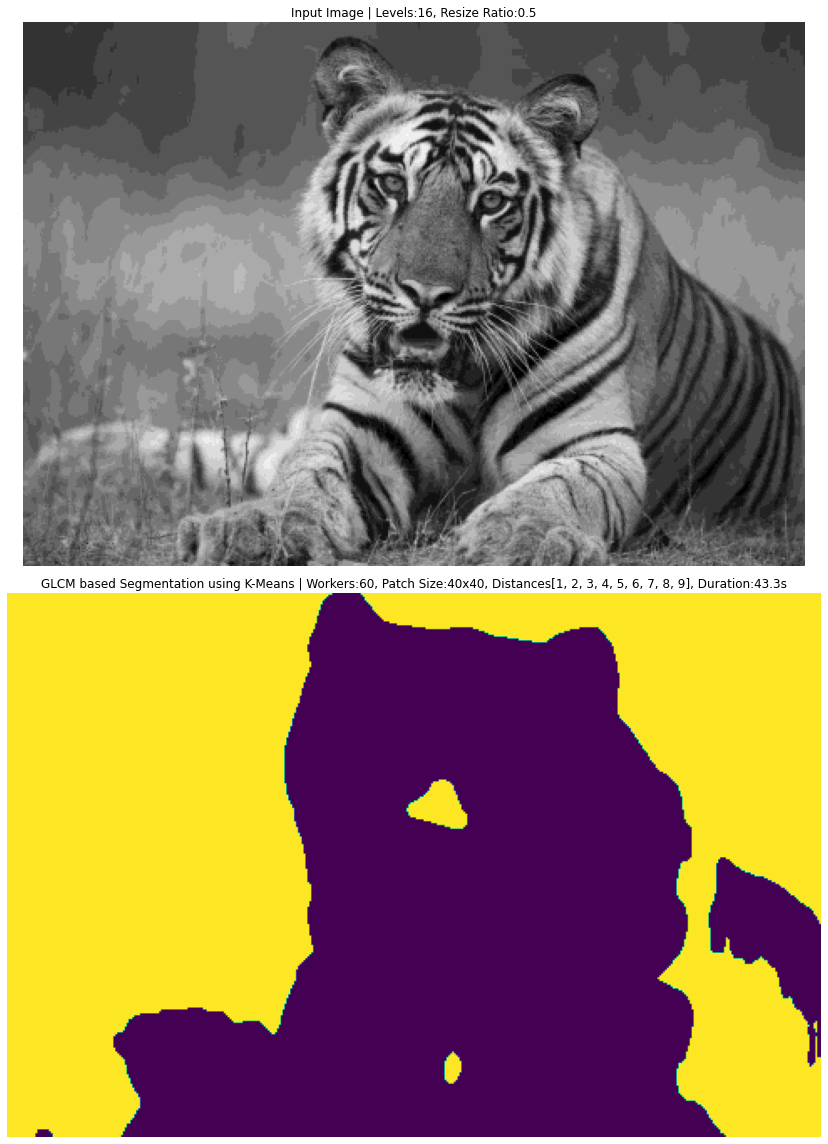

In [13]:
Segmentation(img_2,p_shape=40,resize_ratio=0.5,levels=16,workers = 60 ,distances=list(range(1,10)), angles=angles, features = features, k=3)
Segmentation(img_2,p_shape=40,resize_ratio=0.5,levels=16,workers = 60 ,distances=list(range(1,10)), angles=angles, features = features, k=2)